In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Importing necessary libraries for document fetching and pre-processing

In [ ]:
import numpy as np,pandas as pd
import re, string, unicodedata
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
#import pickle
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Importing necessary documents for model building and evaluation

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,accuracy_score
import matplotlib.pyplot as plt

# Read the data and understand it

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/kaggle/train.tsv', delimiter='\t')
test_data = pd.read_csv('/content/drive/MyDrive/kaggle/test.tsv', delimiter='\t')

In [ ]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
test_data.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


### Remove un-necessary attributes

In [ ]:
classes = ["negative","somewhat negative","neutral","somewhat positive","positive"]
train_data.drop(["PhraseId","SentenceId"],axis=1,inplace=True)

# Check if there are any missing values in the dataset

In [ ]:
train_data.isnull().sum()

Phrase       0
Sentiment    0
dtype: int64

# Check the distribution of classes in the dataset

In [ ]:
k = train_data["Sentiment"].value_counts()
k1 = pd.DataFrame([k[0],k[1],k[2],k[3],k[4]],index=classes,columns=["Count"])

The classes are not uniformly distributed which may be a cause for hampering our model 

In [ ]:
k1

,Count
negative,7072
somewhat negative,27273
neutral,79582
somewhat positive,32927
positive,9206


In [ ]:
list(k1["Count"])

[7072, 27273, 79582, 32927, 9206]

(-1.1090821199443506,
 1.1004324849338496,
 -1.1214182180460146,
 1.1087858778342818)

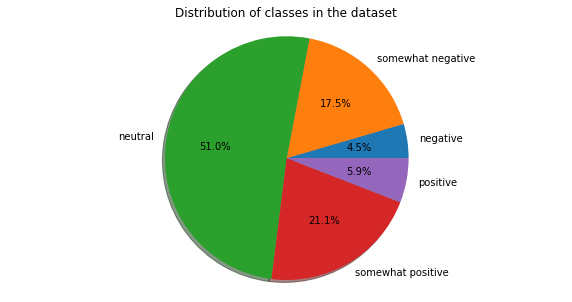

In [ ]:
plt.figure(figsize=(10,5))
plt.pie(list(k1["Count"]),labels=classes,autopct='%1.1f%%',shadow=True)
plt.title("Distribution of classes in the dataset")
plt.axis("equal")

# Functions to pre-process a phrase

In [ ]:
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        if new_word!="":
            new_words.append(new_word)
    return new_words

def to_lowercase(words):
    return [word.lower() for word in words]

def remove_numbers(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'\d+','',word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    stop_words = set(stopwords.words("english"))-{"above","couldn't","didn't","did","below","dosen't","don't","not","very","won't","wouldn't"}
    return [word for word in words if word not in stop_words]

def stem_words(words):
    stemmer = LancasterStemmer()
    return [stemmer.stem(word) for word in words]

In [ ]:
def lexical_analysis(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_numbers(words)
    return words

def preprocess(phrase):
    phrase = phrase.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    words = word_tokenize(phrase)
    words = lexical_analysis(words)
    words = remove_stopwords(words)
    words = stem_words(words)
    words = remove_stopwords(words)
    return words

In [ ]:
corpus = []
for phrase in train_data["Phrase"]:
    review = preprocess(phrase)
    review = ' '.join(review)
    corpus.append(review)

# Divide the entire training set ( 80% training and 20% test)

In [ ]:
from sklearn.model_selection import train_test_split
X_train1,X_test1,y_train,y_test = train_test_split(corpus,train_data["Sentiment"], test_size = 0.2, random_state = 42)

# Converting text to numerical data using tf-idf vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
X_train_tiv = tf_idf_vect.transform(X_train1)
X_test_tiv = tf_idf_vect.transform(X_test1)

In [ ]:
results = {}
results["Naive Bayes"] = {}
results["KNN"] = {}
results["SVM"] = {}

# Model Creation, training and testing

# Naive Bayes (train using td-idf vectorized data)

In [ ]:
nb_tiv = MultinomialNB()
nb_tiv.fit(X_train_tiv,y_train)
y_pred_nb = nb_tiv.predict(X_test_tiv)

In [ ]:
print(classification_report(y_test ,y_pred_nb, target_names=classes ))
a = nb_tiv.score(X_test_tiv,y_test)
print('Accuracy: ', a)
results["Naive Bayes"]['Testing'] = a
results["Naive Bayes"]['Training'] = nb_tiv.score(X_train_tiv,y_train)

                   precision    recall  f1-score   support

         negative       0.65      0.04      0.07      1416
somewhat negative       0.52      0.22      0.31      5527
          neutral       0.58      0.91      0.71     15639
somewhat positive       0.52      0.32      0.40      6707
         positive       0.56      0.04      0.08      1923

         accuracy                           0.57     31212
        macro avg       0.57      0.31      0.31     31212
     weighted avg       0.56      0.57      0.51     31212

Accuracy:  0.5707099833397411


# KNN (TF - IDF Vectorizer)

In [ ]:
knn_tiv = KNeighborsClassifier(n_neighbors=5)
knn_tiv.fit(X_train_tiv,y_train)
y_pred_knn = knn_tiv.predict(X_test_tiv)

In [ ]:
print(classification_report(y_test ,y_pred_knn, target_names=classes ))
results["KNN"]['Testing'] = knn_tiv.score(X_test_tiv,y_test)
results["KNN"]['Training'] = knn_tiv.score(X_train_tiv,y_train)

                   precision    recall  f1-score   support

         negative       0.42      0.38      0.40      1416
somewhat negative       0.51      0.48      0.49      5527
          neutral       0.67      0.80      0.73     15639
somewhat positive       0.55      0.42      0.47      6707
         positive       0.56      0.28      0.37      1923

         accuracy                           0.61     31212
        macro avg       0.54      0.47      0.49     31212
     weighted avg       0.60      0.61      0.60     31212



# SVM (TF IDF Vectorizer)

In [ ]:
SVM_tiv = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM_tiv.fit(X_train_tiv,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
results["SVM"]['Testing'] = SVM_tiv.score(X_test_tiv,y_test)
results["SVM"]['Training'] = SVM_tiv.score(X_train_tiv,y_train)

In [ ]:
pd.DataFrame(results)

,Naive Bayes,KNN,SVM
Testing,0.570710,0.609926,0.62194
Training,0.602164,0.728654,0.65607


In [ ]:
nb_tiv

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

•	SVM performed the best for the dataset considered. Even though the training set accuracy was maximum for KNN but it showed less accuracy against test set but there wasn’t much decrease in accuracy from training set to test set for SVM

•	The accuracies of models are average and it may be due to the following reasons.<br<<br>
  •	<strong>Related to dataset</strong>
    1.	The number of training examples for positive and negative examples are very low
    2.	The class distribution is not uniform. Its evident from f1 score column of Claasification report when test set was predicted using KNN that the model is biased towards neutral class 
    
                              precision recall    f1-score support

         negative      		    0.42      0.38      0.40      1416
         somewhat negative         0.51      0.48      0.49      5527
         neutral       		    0.67      0.80      0.73      15639
         somewhat positive         0.55      0.42      0.47      6707
         positive       		   0.56      0.28      0.37      1923

         accuracy                            		  0.61      31212
         macro avg       		  0.54      0.47      0.49      31212
         weighted avg       	   0.60      0.61      0.60      31212
<i>Probable Solution</i> : A dataset with large number of tuples for each class and distribution of classes are equal

•	<strong>Related to Models</strong> : 
      The machine learning models used do not store sequence           information. But its commonly the case that meaning of a word has to be inferred based on any other word which is used earlier or later. For example, consider the phrase ‘not good’. It is negative sentence but due to the presence of word good and with no information about the past words the model will predict it as positive.<br>
<i>Probable Solution</i> : Use of advanced NLP techniques which can store sequence information such as LSTM.
